In [2]:
#|default_exp augment

# Augmentation

In [3]:
#|export
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *

In [4]:
from diy_stable_diffusion import resnet
import diy_stable_diffusion

In [5]:
dir(diy_stable_diffusion)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'activations',
 'conv',
 'datasets',
 'init',
 'learner',
 'resnet',
 'sgd',
 'training']

In [6]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [7]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

'''
Note to self: remember that a lot of this library code is written to essentially accept instantiable method references or callbacks,
hence creating these partials here to be later used as either callbacks given to pytorch for initializing tensor weights (iw) or
to be invoked directly like constructors (act_gr, which will be invoked as act=act() in an __init__ method somewhere).
'''
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [9]:
set_seed(42)
lr,epochs = 6e-2,5

## Going wider

In [10]:
def get_model(act=nn.ReLU, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 32, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [11]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

learn.fit(epochs)

In [12]:
#learn.fit(10)

In [13]:
'''
Note: this is just to keep training the above model a bit longer, the scheduler chosen doesn't like it when you just
chuck more epochs into trianing the model because you prescribe the number of training steps when initializing the
scheduler and if you try to train more, it chokes, not having scheduled a learning rate or momentum etc for that step.
'''
lr = 1e-2
tmax = 5 * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [14]:
#learn.fit(5)

# Pooling

In [15]:
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        return x.mean((-1, -2))


In [16]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [17]:
# skip a few preliminary ones from the lesson
def get_model4(act=nn.ReLU, channels=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, kernel_size=5, stride=1, activation=act, norm=norm)]
    layers += [ResBlock(channels[i], channels[i+1], stride=2, act=act,norm=norm) for i in range(len(channels) - 1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [18]:
l=[o for o in get_model4()]

In [19]:
len(l),l[0],[[a.shape for a in o.parameters()] for o in l[0]]

(8,
 Sequential(
   (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 [[torch.Size([16, 1, 5, 5]), torch.Size([16])],
  [torch.Size([16]), torch.Size([16])],
  []])

In [20]:
'''
seems as though BatchNorm2d has two learnable parameters for each channel it normalizes.
The center and scale parameters, gamma and beta.
'''
batchnorm=l[0][1]
[p.shape for p in batchnorm.parameters()]

[torch.Size([16]), torch.Size([16])]

In [21]:
'''
In network described below, GlobalAveragePooling acts to reduce 256 channels of 2x2 feature maps into 256 averages. 
In this view, each of the 4 elements in a channel represents an addition or subtraction to the idea represented by
the whole channel, because each element is treated without regard to its position when they're all averaged.

Hence GlobalAvgPool here reduces a tensor of shape (batch_size, channel_count, height, width) into just (batch_size, channel_count)
in this case reducing (1024, 256, 2, 2) to (1024, 256). Hence a linear lay succeeding it maps a 256 feature vector to a 10
feature vector (the number of output classifications).
'''

"\nIn network described below, GlobalAveragePooling acts to reduce 256 channels of 2x2 feature maps into 256 averages. \nIn this view, each of the 4 elements in a channel represents an addition or subtraction to the idea represented by\nthe whole channel, because each element is treated without regard to its position when they're all averaged.\n\nHence GlobalAvgPool here reduces a tensor of shape (batch_size, channel_count, height, width) into just (batch_size, channel_count)\nin this case reducing (1024, 256, 2, 2) to (1024, 256). Hence a linear lay succeeding it maps a 256 feature vector to a 10\nfeature vector (the number of output classifications).\n"

In [22]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [23]:
set_seed(42)
model=get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra,opt_func=optim.AdamW)

In [24]:
#learn.fit(epochs)

In [25]:
lr=1e-2

In [26]:
set_seed(42)
model=get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra,opt_func=optim.AdamW)

In [27]:
#learn.fit(epochs)

In [28]:
tmax,lr,len(dls.train)

(295, 0.01, 59)

# Note for above ^^ figure out why accuracy not as good as Jeremy's
Ok, I did the same architecture the first time an repeatedly got results about two percentage points lower accuracy than Jeremy's. It's because I had used a larger batch size, I think in order to speed up training time for the really wide networks I tried. When ran the second time I got .927 accuracy, the first time with batch size 4096 is the one with .904 accuracy.

# Data augmentation

In [29]:
from torchvision import transforms

In [30]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop):
    return tfm_x(b[0]), tfm_y(b[1])

tfm = nn.Sequential(transforms.RandomCrop(28, padding=4),
                    transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfm), on_val=False)
learn = TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [31]:
#learn.fit(1)

In [32]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

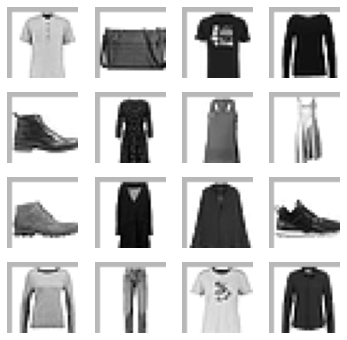

In [33]:
learn.show_image_batch(max_n=16, imsize=1.5)

In [34]:
tfm = nn.Sequential(transforms.RandomCrop(28, padding=1),
                    transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfm), on_val=False)

In [35]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [36]:
cbs,xtra

([<diy_stable_diffusion.learner.DeviceCB at 0x7fd68251a6d0>,
 [<diy_stable_diffusion.sgd.BatchSchedCB at 0x7fd68251a3a0>])

### no weight initialization, attempt 1 (better than with weight init from Jeremy)

In [37]:
epochs=4
lr=1e-2
tmax=epochs*len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra=[BatchSchedCB(sched), augcb]
model=get_model(act_gr, norm=nn.BatchNorm2d)#.apply(iw)
learn=TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [38]:
#learn.fit(epochs)

### attempt #2 to replicate

In [39]:
epochs=4
lr=1e-2
tmax=epochs*len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra=[BatchSchedCB(sched), augcb]
model=get_model(act_gr, norm=nn.BatchNorm2d)#.apply(iw)
learn=TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [40]:
#learn.fit(epochs)

### No weight init OR batch normalization in resblocks/convs

In [41]:
epochs=4
lr=1e-2
tmax=epochs*len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra=[BatchSchedCB(sched), augcb]
model=get_model(act_gr, norm=None)#.apply(iw)
learn=TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [42]:
#learn.fit(epochs)

### ok now try 20 epochs like Jeremy

In [43]:
epochs=20
lr=1e-2
tmax=epochs*len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra=[BatchSchedCB(sched), augcb]
model=get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn=TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [44]:
#learn.fit(epochs)

In [45]:
model_path=Path('models')
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path/'data_aug.pkl')

# Test time augmentation, tta

In [46]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn):
        self.all_inps = []
        self.all_preds = []
        self.all_targs = []
    
    def after_batch(self, learn):
        self.all_inps.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
                              
    def after_fit(self, learn):
        self.all_inps  = torch.cat( self.all_inps )
        self.all_preds = torch.cat( self.all_preds)                    
        self.all_targs = torch.cat( self.all_targs)

In [47]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    predscb = CapturePreds()
    self.fit(1, do_train=False, cbs=[predscb]+fc.L(cbs))
    res = predscb.all_preds, predscb.all_targs
    if inps:
        res = res + (predscb.all_inps,)
    
    return res

# Random erase

In [49]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]

In [50]:
random.random?

Signature: random.random()
Docstring: random() -> x in the interval [0, 1).
Type:      builtin_function_or_method


In [51]:
#|export
def _rand_erase1(x, pct, xmean, xstd, xmin, xmax):
    size_x = int(pct * x.shape[-2])
    size_y = int(pct * x.shape[-1])
    start_x = int((1-pct) * x.shape[-2] * random.random())
    start_y = int((1-pct) * x.shape[-1] * random.random())
    init.normal_(x[:, :, start_x:start_x+size_x, start_y:start_y+size_y], xmean, xstd)
    x.clamp_(xmin, xmax)

In [52]:
#|export

def rand_erase(x, pct=0.2, max_num=4):
    for i in range(random.randint(0, max_num)):
        _rand_erase1(x, pct, x.mean(), x.std(), x.min(), x.max())
    return x
                   
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct, self.max_num = pct, max_num
    
    def forward(self, x):
        return rand_erase(x, self.pct, self.max_num)

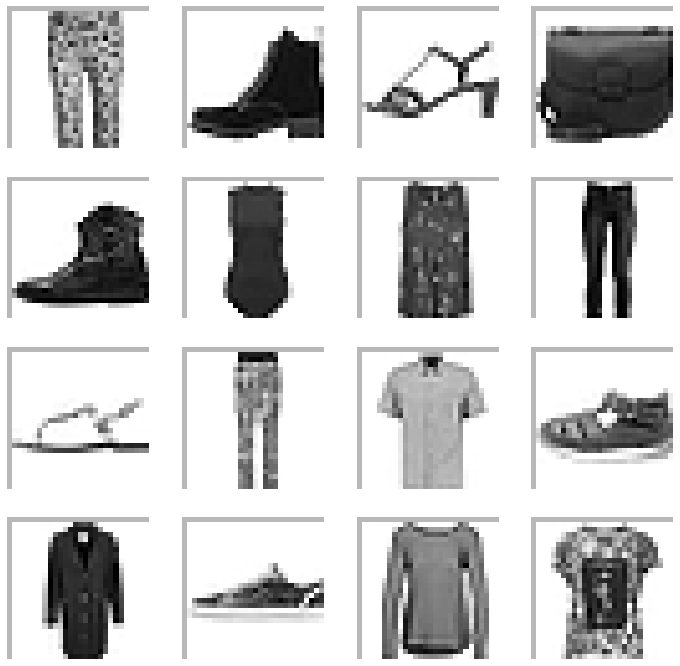

In [53]:
tfm = nn.Sequential(transforms.RandomCrop(28, padding=1),
                    transforms.RandomHorizontalFlip(),
                    RandErase())

aug_callback= BatchTransformCB(partial(tfm_batch, tfm_x=tfm))
learn=TrainLearner(get_model(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), aug_callback])
learn.fit(1)
xb,yb=learn.batch
show_images(xb[:16])

In [108]:
def get_model6(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(0.1)]
    for i in range(len(nfs)-1):
        layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2), nn.Dropout2d(0.3)]
    layers += [nn.Flatten(), nn.Dropout1d(0.3), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [120]:
epochs = 5
lr = 1e-1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
model = get_model6(act_gr, norm=nn.BatchNorm2d).apply(iw)

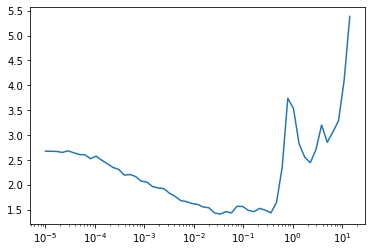

In [110]:
xtra = [aug_callback]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.lr_find()

accuracy,loss,epoch,train
0.548,1.248,0,train
0.796,0.570,0,eval
0.606,1.049,1,train
0.844,0.427,1,eval
0.632,0.969,2,train
0.881,0.340,2,eval
0.651,0.913,3,train
0.898,0.303,3,eval
0.663,0.879,4,train
0.908,0.275,4,eval


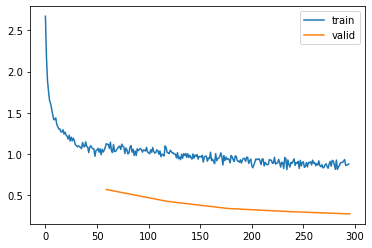

In [121]:
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train
0.639,0.952,0,train
0.825,0.485,0,eval
0.601,1.063,1,train
0.846,0.420,1,eval
0.619,1.005,2,train
0.851,0.420,2,eval
0.634,0.951,3,train
0.885,0.344,3,eval
0.647,0.917,4,train
0.891,0.321,4,eval


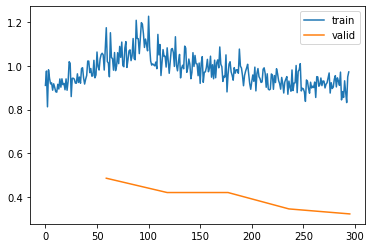

In [125]:
# got 0.875 	0.377 	4 	eval when doing it the first time
# 0.891 	0.321 	4 	eval the second time 
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), aug_callback]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train
0.878,0.364,0,eval


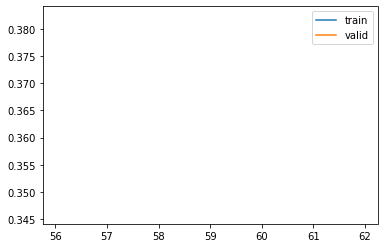

In [123]:
learn.fit(1, do_train=False)

In [124]:
model_path=Path('models')
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path/'trytowin2.pkl')
#learn.model = torch.load( model_path/'trytowin.pkl')

accuracy,loss,epoch,train
0.124,3.955,0,eval


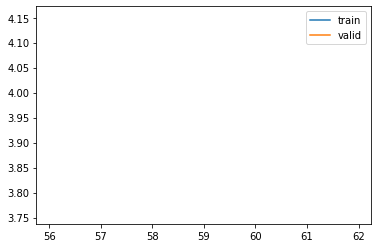

In [90]:
cap = CapturePreds()

learn.fit(1, do_train=False, do_validate=True, cbs=[cap])

In [88]:
(cap.all_preds.argmax(1) == cap.all_targs).float().mean().item()

0.12439999729394913

 accuracy 	loss 	epoch 	train
0.747 	0.913 	0 	train
0.800 	0.723 	0 	eval
0.841 	0.632 	1 	train
0.816 	0.688 	1 	eval
0.861 	0.538 	2 	train
0.842 	0.557 	2 	eval
0.868 	0.475 	3 	train
0.815 	0.593 	3 	eval
0.876 	0.410 	4 	train
0.821 	0.574 	4 	eval
0.883 	0.363 	5 	train
0.851 	0.452 	5 	eval
0.885 	0.343 	6 	train
0.868 	0.379 	6 	eval
0.896 	0.304 	7 	train
0.866 	0.379 	7 	eval
0.894 	0.304 	8 	train
0.817 	0.526 	8 	eval
0.898 	0.295 	9 	train
0.837 	0.471 	9 	eval
0.904 	0.271 	10 	train
0.881 	0.338 	10 	eval
0.906 	0.267 	11 	train
0.852 	0.426 	11 	eval
0.912 	0.248 	12 	train
0.891 	0.328 	12 	eval
0.911 	0.249 	13 	train
0.863 	0.447 	13 	eval
0.917 	0.231 	14 	train
0.867 	0.388 	14 	eval
0.917 	0.226 	15 	train
0.866 	0.381 	15 	eval
0.922 	0.212 	16 	train
0.859 	0.402 	16 	eval
0.921 	0.216 	17 	train
0.871 	0.383 	17 	eval
0.927 	0.205 	18 	train
0.886 	0.336 	18 	eval
0.925 	0.207 	19 	train
0.889 	0.320 	19 	eval
0.926 	0.200 	20 	train
0.877 	0.343 	20 	eval
0.930 	0.192 	21 	train
0.905 	0.274 	21 	eval
0.934 	0.184 	22 	train
0.908 	0.250 	22 	eval
0.933 	0.181 	23 	train
0.902 	0.263 	23 	eval
0.934 	0.182 	24 	train
0.902 	0.269 	24 	eval
0.939 	0.170 	25 	train
0.903 	0.266 	25 	eval
0.940 	0.163 	26 	train
0.903 	0.284 	26 	eval
0.943 	0.159 	27 	train
0.918 	0.229 	27 	eval
0.943 	0.156 	28 	train
0.916 	0.240 	28 	eval
0.942 	0.161 	29 	train
0.910 	0.256 	29 	eval
0.945 	0.150 	30 	train
0.919 	0.236 	30 	eval
0.947 	0.144 	31 	train
0.911 	0.245 	31 	eval
0.949 	0.139 	32 	train
0.927 	0.210 	32 	eval
0.949 	0.136 	33 	train
0.925 	0.218 	33 	eval
0.952 	0.133 	34 	train
0.924 	0.217 	34 	eval
0.954 	0.126 	35 	train
0.932 	0.202 	35 	eval
0.956 	0.119 	36 	train
0.924 	0.224 	36 	eval
0.958 	0.115 	37 	train
0.933 	0.202 	37 	eval
0.959 	0.112 	38 	train
0.929 	0.209 	38 	eval
0.962 	0.103 	39 	train
0.934 	0.191 	39 	eval
0.965 	0.098 	40 	train
0.928 	0.212 	40 	eval
0.967 	0.091 	41 	train
0.933 	0.205 	41 	eval
0.969 	0.085 	42 	train
0.934 	0.209 	42 	eval
0.972 	0.080 	43 	train
0.934 	0.205 	43 	eval
0.972 	0.077 	44 	train
0.936 	0.198 	44 	eval
0.972 	0.077 	45 	train
0.939 	0.188 	45 	eval
0.973 	0.076 	46 	train
0.938 	0.188 	46 	eval
0.977 	0.066 	47 	train
0.942 	0.182 	47 	eval
0.975 	0.071 	48 	train
0.936 	0.205 	48 	eval
0.976 	0.069 	49 	train
0.934 	0.200 	49 	eval

# Random copy
Note: this section cut pasted.

In [60]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

In [61]:
#|export
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
#     print(num)
    return x

In [62]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [63]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

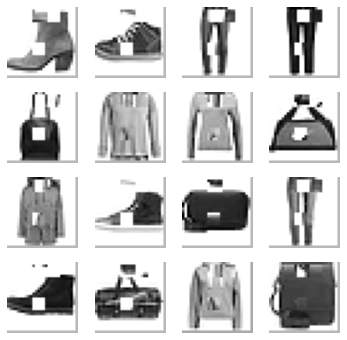

In [64]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

# Dropout

In [65]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        if not self.training:
            return x
        
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device),
                                               probs=(1-self.p))
        '''
        sample a tensor of same shape as x. Different activations
        are dropped for each example in minibatch.
        
        To drop the same activations from each element in the batch
        you would sample with: dist.sample((x.shape[-1],)). `sample`
        method must takes a "size" tuple.
        
        Dropping some multiplicands lowers some statistics of the layer
        so restore them by scaling the remaining activations back up. 
        Preserves variance I think.
        '''
        return x * dist.sample(x.size()) / (1-self.p)

In [66]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(0.1)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(0.1), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [67]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

#Note: final result 0.931 	0.220 	4 	eval

learn.fit(epochs)

## Homemade dropout2d

In [68]:
class Dropout2d(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p=p
        self.dist = distributions.binomial.Binomial(tensor(1.).to(def_device), probs=(1-self.p))
    def forward(self, x):
        drop = self.dist.sample((x.shape[-3], 1, 1))
        return drop * x / (1-self.p)

In [69]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), Dropout2d(0.1)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(0.1), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [70]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [71]:
# got .91 or something first time, .921 second time
#learn.fit()

# 1cycle scheduler

In [72]:
class OneCycleLR():
    def __init__(self, opt, max_lr, n_steps):
        self.sched = torch.cat((
            torch.linspace(max_lr/4, max_lr, n_steps // 2),
            torch.linspace(max_lr, max_lr/4, n_steps // 2)
        ))
        if n_steps % 2 == 1:
            self.sched = torch.cat((self.sched, tensor(max_lr/4)[None]))
        
        self.opt = opt
        self.i = 0
    def step(self):
        if self.i < self.sched.shape[0]:
            self.opt.param_groups[0]['lr'] = self.sched[self.i]
        else:
            print('OneCycleLR: warning, going over max num steps')
        self.i = self.i + 1
        

In [73]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(OneCycleLR, max_lr=lr, n_steps=tmdax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

NameError: name 'tmdax' is not defined

In [ ]:
learn.fit(5)